In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ssqueezepy import cwt,icwt,Wavelet,ssq_cwt,issq_cwt
from ssqueezepy.experimental import scale_to_freq
import matplotlib.gridspec as gridspec
import time
import sys
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.optimize import curve_fit
from vmdpy import VMD
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import gc
#--------------------------------------------------------------------------
machine_epsilon = sys.float_info.epsilon



In [ ]:
def gauss1(x, a1, b1, c1):
    return a1 * np.exp(-((x - b1)**2) / (2 * c1**2))



def cal_pp1(W):
    WW_abs=np.abs(W)
    WW_abs=WW_abs+np.mean(WW_abs)
    xu=np.linspace(0,W.shape[0]-1,W.shape[0])
    pp=np.zeros(W.shape[0])
    for i in range(W.shape[0]):
        prob_dist = WW_abs[i, :] / (np.sum(WW_abs[i, :]) + 1e-8)
        pp[i] = -np.sum(prob_dist * np.log(prob_dist + 1e-8))
    pp=1-(pp-np.min(pp))/(np.max(pp)-np.min(pp))

    xData = np.ravel(xu)
    yData = np.ravel(pp)
    mm = np.max(yData)   
    nn_index = np.argmax(yData)       
    b1_guess = xData[nn_index]        
    c1_guess = (np.max(xData) - b1_guess) / 3  
    initial_guess = [mm, b1_guess, c1_guess]
    param_bounds = ([-np.inf, -np.inf, 0], [np.inf, np.inf, np.inf])
    popt, pcov = curve_fit(gauss1, xData, yData, p0=initial_guess, bounds=param_bounds,maxfev=5000) 

    a1_fit, b1_fit, c1_fit = popt
    st1 = max(int(np.ceil(b1_fit - 3*c1_fit)), 0)
    ed1 = min(int(np.floor(b1_fit + 3*c1_fit)), W.shape[0]-1)
    return st1,ed1

def para_free_denoising_v5zhao(data, org_tf, f, nrs, f_s, f_e):
    id = len(data)
    noise_rov = np.zeros(id)
    start_s = int(np.floor(id / nrs))
    end_s = start_s
    for i in range(start_s, id - end_s):
        var_front = np.var(data[0:i+1])  
        var_back = np.var(data[i:])     
        if var_back != 0:
            noise_rov[i] = var_front / var_back
        else:
            noise_rov[i] = np.inf
    search_range = noise_rov[start_s:id-end_s]
    if len(search_range) > 0:
        noise_t_rel = np.argmin(search_range)
        noise_tt = noise_t_rel + start_s + 1  
    else:
        noise_tt = start_s + 1
    fi1 = np.argmin(np.abs(f_s - f))
    fi2 = np.argmin(np.abs(f_e - f))
    f_x = np.zeros_like(org_tf)
    thre = np.zeros(org_tf.shape[0])
    
    for i in range(fi1, fi2 + 1):  
        wk = org_tf[i, :]
        noise_wk = np.abs(wk[0:noise_tt])
        mad_val = np.mean(np.abs(noise_wk - np.mean(noise_wk)))
        thre1 = np.sqrt(2 * np.log(noise_tt)) * mad_val / 0.67
        mask = noise_wk >= thre1
        if np.any(mask):
            thre_a = np.mean(noise_wk[mask])
        else:
            thre_a = thre1
        thre_b = np.max(np.abs(wk))
        interval = [thre_a, thre_b]
        _, gcv_thre = fibonacci_v2(wk, interval)
        f_x[i, :] = thresh(wk, gcv_thre)
        thre[i] = gcv_thre
 
    return f_x

def thresh(y, t):
    res = np.abs(y) - t
    x = (np.sign(res) + 1) * y / 2
    return x



def fibonacci_v2(y, interval):
    a, b = interval[0], interval[1]
    F = [1, 1]
    n = 2
    while n < 20:
        F.append(F[n-1] + F[n-2])
        n += 1
    n = len(F) - 1
    x1 = a + (F[n-2] / F[n]) * (b - a)
    x2 = a + (F[n-1] / F[n]) * (b - a)
    f1 = gcv(y, x1)
    f2 = gcv(y, x2)
    k = 0
    while n > 3:
        k += 1
        n -= 1
        
        if f1 > f2:
            a = x1
            x1 = x2
            f1 = f2
            if n >= 1:
                x2 = a + (F[n-1] / F[n]) * (b - a)
                f2 = gcv(y, x2)
        elif f1 == f2:
            a = x1
            b = x2
            if n >= 2:
                x1 = a + (F[n-2] / F[n]) * (b - a)
                x2 = a + (F[n-1] / F[n]) * (b - a)
                f1 = gcv(y, x1)
                f2 = gcv(y, x2)
        else:
            b = x2
            x2 = x1
            f2 = f1
            if n >= 2:
                x1 = a + (F[n-2] / F[n]) * (b - a)
                f1 = gcv(y, x1)
    x = (a + b) / 2
    return k, x

def gcv(j, t):
    N = len(j)
    res = np.abs(j) - t
    N0 = np.sum(res <= 0) 
    y = np.sign(j) * res * (res >= 0)
    if N0 == 0:
        gcv_val = 0
    else:
        gcv_val = N * (np.linalg.norm(y - j) / N0) ** 2
    return gcv_val



In [4]:
def new_method(W,st1,ed1):
    W1=W[st1+1:ed1].copy()
    W1_abs=np.abs(W1)
    I=W1_abs.sum(axis=0)
    I_min=np.min(I)
    I_max=np.max(I)
    I_norm=(I - I_min) / (I_max - I_min+machine_epsilon)
    I_1=W1_abs.copy()

    for i in range(W1.shape[0]):
        I_norm_1=I_norm.copy()
        W_abs_f=W1_abs[i,:]
        W_abs_f_min=np.min(W_abs_f)
        W_abs_f_max=np.max(W_abs_f)
        W_norm_f=(W_abs_f - W_abs_f_min) / (W_abs_f_max - W_abs_f_min+machine_epsilon)
        mask=I_norm_1>W_norm_f
        I_norm_1[mask]=W_norm_f[mask]
        I_1[i,:]=I_norm_1*(I_max - I_min)+I_min

    W2=W1/(I_1+machine_epsilon)
    W2_abs=np.abs(W2)
    #-------------------------------------------------------------------
    nk=100
    curve=np.zeros((nk))
    nnn=np.linspace(np.min(I_1), np.max(I_1),nk)
    ik=0
    for i in nnn:
        curve[ik]=np.sum(np.abs(W1_abs-i*W2_abs))
        if ik > 0:
            if curve[ik] > curve[ik - 1]:  
                break
        ik=ik+1
    #-------------------------------------------------------------------
    curve1=np.zeros((nk))
    nnn1=np.linspace(nnn[np.max([ik-2,0])], nnn[ik],nk)
    ik1=0
    for i in nnn1:
        curve1[ik1]=np.sum(np.abs(W1_abs-i*W2_abs))
        if ik1 > 0:
            if curve1[ik1] > curve1[ik1 - 1]:  
                break
        ik1=ik1+1
    k=nnn1[np.max(ik1-1,0)]
    #-------------------------------------------------------------------
    W2_k=W2*k
    W2_kabs=np.abs(W2_k)
    W3=W1-W2_k   
    mask=W2_kabs>W1_abs  
    W3[mask]=0
    W3_abs=np.abs(W3)
    W3=W3*np.max(I-I_min)/np.max(W3_abs.sum(axis=0))

    W3_3=W.copy()
    W3_3[:st1+1,:]=0
    W3_3[ed1:,:]=0
    W3_3[st1+1:ed1]=W3

 
    return W3_3


In [ ]:

def hard_thre(W,Lamda):
    W_hard=W.copy()
    W_hard_abs=np.abs(W_hard)
    for i in range(W_hard_abs.shape[0]):
        nn = W_hard_abs[i, :] < Lamda[i]  
        W_hard[i, nn] = 0  
    return W_hard


def soft_thre(W,Lamda):
    W_soft=W.copy()
    W_soft_abs=np.abs(W_soft)
    for i in range(W_soft.shape[0]):
        W_soft_abs[i, :]  = np.maximum(0, W_soft_abs[i, :]  - Lamda[i])
    W_soft=W_soft/np.abs(W_soft)*W_soft_abs
    return W_soft

 
def jingyi_thre(W,Lamda,alpha):
    WW_soft_new=W.copy()
    WW_soft_new_abs=np.abs(WW_soft_new)
    for i in range(WW_soft_new.shape[0]):
        nn = WW_soft_new_abs[i, :] >= Lamda[i]  
        WW_soft_new_abs[i, nn]  =  WW_soft_new_abs[i, nn]  - Lamda[i]/(np.exp(3*alpha*(WW_soft_new_abs[i, nn] -Lamda[i])/Lamda[i]))
        nn = WW_soft_new_abs[i, :] < Lamda[i]  
        WW_soft_new_abs[i, nn]=0
    WW=WW_soft_new_abs*WW_soft_new/np.abs(WW_soft_new)
    return WW
 

def zhang_thre(W,Lamda,A):
    WW_soft_new1=W.copy()
    WW_soft_new1_abs=np.abs(WW_soft_new1)
    for i in range(WW_soft_new1_abs.shape[0]):
        nn = WW_soft_new1_abs[i, :] >= Lamda[i]  
        WW_soft_new1_abs[i, nn]  = WW_soft_new1_abs[i, nn] -Lamda[i]*(A/np.max(WW_soft_new1_abs[i, :]))**(1/2)
        nn = WW_soft_new1_abs[i, :] < Lamda[i]  
        WW_soft_new1_abs[i, nn]=0
    WW=WW_soft_new1_abs* WW_soft_new1/np.abs(WW_soft_new1)
    return WW



  
def cal_thre(W_abs):
    N=W_abs.shape[1]
    Lamda=np.zeros(W_abs.shape[0])
    for i in range(W_abs.shape[0]):
        Lamda[i]=np.median(W_abs[i,:]) / 0.6745 * np.sqrt(2 * np.log(N))/np.log2(i+1+1)
    return Lamda



In [5]:
w=np.load('xx01.npy', allow_pickle=True)
w=w[1200:2200]
fs=500
w_max=np.max(w)
w_min=np.min(w)
w=2*(w-w_min)/(w_max-w_min)-1
 
loaded_data = np.load('Wave_noise_500.npz')
noise=loaded_data['Wave']
for i in range(noise.shape[0]):
    noise[i,:]=noise[i,:]+w
SN=loaded_data['SN']
t = loaded_data['t']
fs = loaded_data['fs']

In [ ]:
Time=np.zeros(5)
nkk=noise.shape[0]
# nkk=10
Result=np.zeros((5,noise.shape[0],noise.shape[1]))
nv = 10
wavelet = Wavelet(wavelet='Morlet')

gc.disable()  
start_time = time.perf_counter()
for i in range(nkk):
    #Adaptive--------------------------------------------------
    s=noise[i,:]
    W,scales= cwt(s, wavelet=wavelet,nv=nv)
    W_abs=np.abs(W)
    Lamda=cal_thre(W_abs)
    W_zhang=zhang_thre(W,Lamda,np.median(np.abs(s)))
    w_zhang=icwt(W_zhang,wavelet=wavelet, nv=nv)
    Result[0,i,:]= w_zhang
end_time = time.perf_counter()
gc.enable()   
Time[0]=end_time - start_time

gc.disable()  
start_time = time.perf_counter()
for i in range(nkk):
    #jing-yi-------------------------------------------------
    s=noise[i,:]
    W,scales= cwt(s, wavelet=wavelet,nv=nv)
    W_abs=np.abs(W)
    Lamda=cal_thre(W_abs)
    alpha=.1
    W_jingyi=jingyi_thre(W,Lamda,alpha)
    w_jingyi=icwt(W_jingyi,wavelet=wavelet, nv=nv)
    Result[1,i,:]= w_jingyi
end_time = time.perf_counter()
gc.enable()  
Time[1]=end_time - start_time



start_time = time.perf_counter()
for i in range(nkk):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # VMD
    s=noise[i,:]
    N=len(s)
    K = 5           
    alpha = 1000    
    tau = 0        
    DC = 0          
    init = 2        
    tol = 1e-7      
    WVMD, u_hat, omega = VMD(s, alpha, tau, K, DC, init, tol)
    for j in range(WVMD.shape[0]):
        WVMD0,scales= cwt(WVMD[j,:], wavelet=wavelet,nv=nv)
        W_absVMD=np.abs(WVMD0)
        LamdaVMD=np.zeros(W_absVMD.shape[0])
        for ii in range(W_absVMD.shape[0]):
            LamdaVMD[ii]=np.median(W_absVMD[ii,:]) / 0.6745 * np.sqrt(2 * np.log(N))/np.log2(ii+1+1)
        W_softVMD=soft_thre(WVMD0,LamdaVMD)
        WVMD[j,:]=icwt(W_softVMD,wavelet=wavelet, nv=nv)
    w_soft=np.sum(WVMD,axis=0)
    Result[2,i,:]= w_soft
end_time = time.perf_counter()
gc.enable()   
Time[2]=end_time - start_time


gc.disable()  
start_time = time.perf_counter()
for i in range(nkk):
    #gcv_liantong-----------------------------------------------------
    s=noise[i,:]
    org_tf, freqs, Wx, scales,= ssq_cwt(s, wavelet,nv=nv)
    f = scale_to_freq(scales, wavelet, len(s), fs=fs)
    f=f[::-1]
    pixel_dw = para_free_denoising_v5zhao(s,org_tf,f,20,0,fs)
    w_gcv=issq_cwt(pixel_dw,wavelet=wavelet)
    Result[3,i,:]= w_gcv
end_time = time.perf_counter()
gc.enable()   
Time[3]=end_time - start_time

gc.disable()  
start_time = time.perf_counter()
for i in range(nkk): 
    # New Method-------------------------------------------------------
    s=noise[i,:]
    W,scales= cwt(s, wavelet=wavelet,nv=nv)
    W_abs=np.abs(W)
    Lamda=cal_thre(W_abs)
    W_zhang=zhang_thre(W,Lamda,np.median(np.abs(s)))
    st1,ed1=cal_pp1(W)
    W4=new_method(W,st1,ed1)
    Xii=np.zeros(W.shape)
    mask=(np.abs(W4)/W_abs>0)&(np.abs(W_zhang)/W_abs>0)
    Xii[mask]=1
    W4=Xii*W4
    w1=icwt(W4,wavelet=wavelet, nv=nv)
    Result[4,i,:]= w1
end_time = time.perf_counter()
gc.enable()   
Time[4]=end_time - start_time

In [63]:
print(Time)

[ 23.8128593  23.8375974 182.3982847  93.2692426  34.5530352]


In [ ]:
# np.savez('Wave_result_500.npz',Result=Result,Time=Time)  

In [6]:
w=np.load('xx01.npy', allow_pickle=True)
w=w[1200:2200]
fs=500
w_max=np.max(w)
w_min=np.min(w)
w=2*(w-w_min)/(w_max-w_min)-1
 
loaded_data = np.load('Wave_noise_500.npz')
noise=loaded_data['Wave']
SN=loaded_data['SN']
t = loaded_data['t']
fs = loaded_data['fs']


loaded_data = np.load('Wave_result_500.npz')
Result=loaded_data['Result']
Time=loaded_data['Time']
n=noise.shape[0]


In [7]:
P_SN=np.zeros((5,n))
P_VA=np.zeros((5,n))
for xu in range(5):
    for i in range(n):
        snr=10*np.log(np.sum(w**2)/np.sum((w-Result[xu,i,:])**2))
        P_SN[xu,i]=snr
        va=np.sqrt(np.sum((w-Result[xu,i,:])**2))
        P_VA[xu,i]=va
VA=SN.copy()
for i in range(noise.shape[0]):
    VA[i]=np.sqrt(np.sum(noise[i,:]**2))

In [8]:
for i in range(P_SN.shape[0]):
    print(np.mean(P_SN[i,:]))
print('------------------------')
for i in range(P_SN.shape[0]):
    print(np.mean(P_VA[i,:]))
print('------------------------')
print(Time/500)
print('------------------------')
print(np.mean(SN))
print(np.mean(VA))

19.98318440178288
17.468528876051018
20.359214248034377
13.337693340258221
29.24204811825552
------------------------
1.1669972119945637
1.3287868914291125
1.1500872337572232
1.626223014858905
0.7428150222716268
------------------------
[0.04762572 0.04767519 0.36479657 0.18653849 0.06910607]
------------------------
-1.8131474856356602
3.4522785094903186


In [ ]:

NN=12
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = NN  
plt.rcParams['axes.labelsize'] = NN  
plt.rcParams['axes.titlesize'] = NN 
plt.rcParams['xtick.labelsize'] = NN  # X
plt.rcParams['ytick.labelsize'] = NN  # Y
plt.rcParams['legend.fontsize'] = NN  
plt.rcParams['axes.labelpad'] =.1
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'  

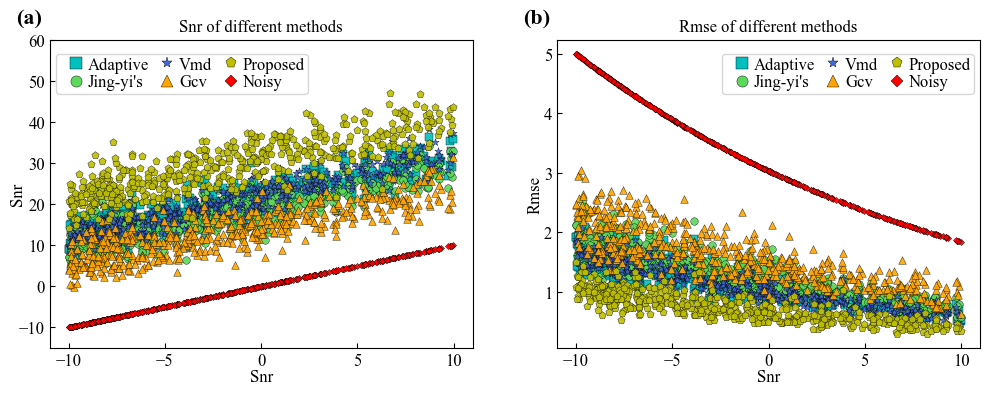

In [ ]:


ln = 0.3
sizes = 30
sizes1 = sizes - 20
plt.figure(figsize=(12, 4))


# ['#4169E1', '#5CD85A', '#FFA500']
color = ['c','#5CD85A','#4169E1', '#FFA500', 'y']
mar = ['s', 'o', '*', '^', 'p']
ax1 = plt.subplot(1, 2, 1)


for xu in range(5):
    plt.scatter(SN, P_SN[xu, :], s=sizes, c=color[xu], marker=mar[xu], alpha=0.9, 
                edgecolors='black', linewidths=ln)

plt.scatter(SN, SN, s=sizes1, c='r', marker="D", alpha=0.9, edgecolors='black', linewidths=ln)
plt.xlabel('Snr')
plt.ylabel('Snr', labelpad=-5)
plt.title('Snr of different methods')
plt.ylim([-15, 60])

ax2 = plt.subplot(1, 2, 2)
for xu in range(5):
    plt.scatter(SN, P_VA[xu, :], s=sizes, c=color[xu], marker=mar[xu], alpha=0.9, 
                edgecolors='black', linewidths=ln)

plt.scatter(SN, VA, s=sizes1, c='r', marker="D", alpha=0.9, edgecolors='black', linewidths=ln)
plt.xlabel('Snr')
plt.ylabel('Rmse', labelpad=0)
plt.title('Rmse of different methods')

# 添加子图标签
labels = ['(a)', '(b)']
for i, ax in enumerate([ax1, ax2]):
    ax.text(-0.08, 1.1, labels[i], transform=ax.transAxes, fontsize=16,  
            weight='bold', color='black', va='top', ha='left')



LA = ["Adaptive", "Jing-yi's", 'Vmd', 'Gcv', 'Proposed', 'Noisy']
handles = []
for i in range(5):
    handle = mlines.Line2D([], [], color=color[i], marker=mar[i], linestyle='None',
                          markersize=8, markeredgecolor='black', markeredgewidth=ln,
                          label=LA[i])
    handles.append(handle)
handle_noisy = mlines.Line2D([], [], color='r', marker='D', linestyle='None',
                           markersize=6, markeredgecolor='black', markeredgewidth=ln,
                           label=LA[5])
handles.append(handle_noisy)
plt.figlegend(handles=handles,
              loc='upper center', 
              bbox_to_anchor=(0.235, 0.85),
              ncol=3,
              borderaxespad=0.1,  
              borderpad=0.2,      
              handletextpad=-0.3,  
              labelspacing=0.1,  
              columnspacing=0.1,
              frameon=True,
              fancybox=True)
plt.figlegend(handles=handles,
              loc='upper center', 
              bbox_to_anchor=(0.79, 0.85),
              ncol=3,
              borderaxespad=0.1,  
              borderpad=0.2,      
              handletextpad=-0.3,  
              labelspacing=0.1,  
              columnspacing=0.1,
              frameon=True,
              fancybox=True)

# plt.savefig('fig9.tif', dpi=650, format="tiff", bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})
plt.show()

In [ ]:
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True) #formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))
formatter_cbar = ScalarFormatter(useMathText=True)
formatter_cbar.set_scientific(True)
formatter_cbar.set_powerlimits((0, 0)) 
nv = 10
wavelet = Wavelet(wavelet='Morlet')
fs=500
W_01,scales= cwt(w, wavelet=wavelet, nv=nv)
freq = scale_to_freq(scales, wavelet, len(w), fs=fs)
ln=1
n_h=1.1
NN=11
selected_freq = freq[np.linspace(0, len(freq)-1, 5).astype(int)]
formatted_labels = [f"{x:.3g}" for x in selected_freq]
mmxx=np.max(w)
vm=np.max(np.abs(W_01))
t=np.linspace(0,len(w)-1,len(w))/fs
tt=np.array([0,250,500,750,1000])


plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = NN  
plt.rcParams['axes.labelsize'] = NN  
plt.rcParams['axes.titlesize'] = NN 
plt.rcParams['xtick.labelsize'] = NN  
plt.rcParams['ytick.labelsize'] = NN  
plt.rcParams['legend.fontsize'] = NN  
plt.rcParams['axes.labelpad'] =.1
plt.rcParams['xtick.direction'] = 'in'  
plt.rcParams['ytick.direction'] = 'in'  


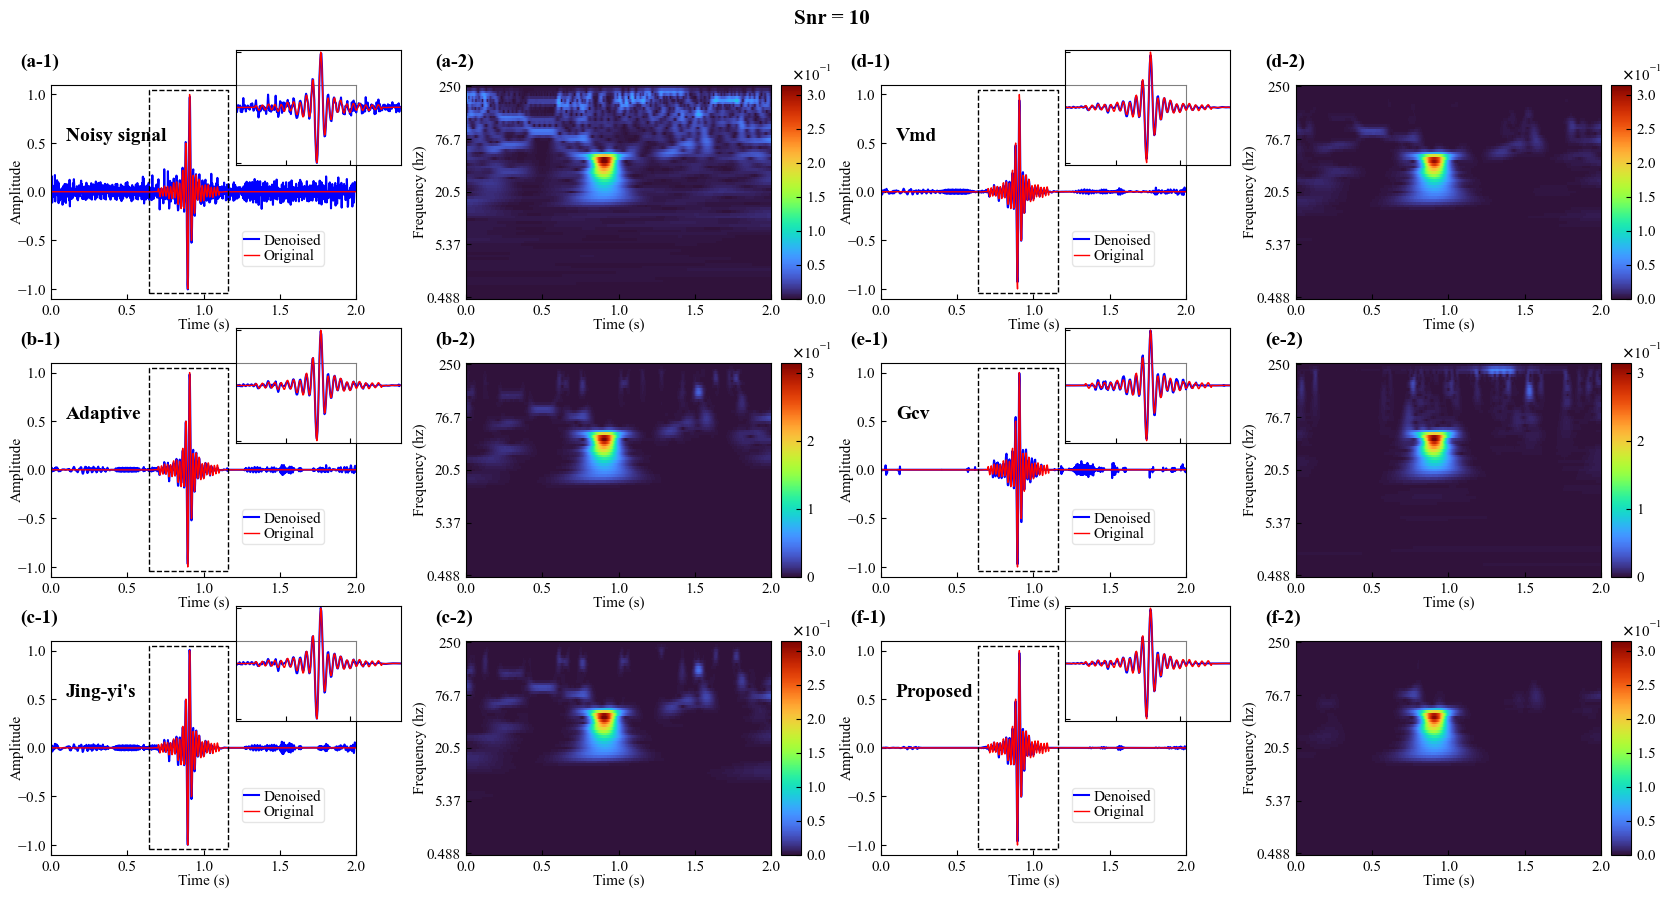

In [ ]:



# kk=121
# nam=['fig8.tif']


# kk=368
# nam=['fig7.tif']


# kk=316
# nam=['fig6.tif']

# kk=249
# nam=['fig5.tif']

sstt1=320
eedd1=580

fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(3,45, height_ratios=[1,1,1],hspace=0.3,figure=fig)
# gs.update(right=0.9)  
xu1=slice(0,9)
xu2=slice(12,21)
xu3=slice(24,33)
xu4=slice(36,45)

ax1 = fig.add_subplot(gs[0, xu1])  
ax2 = fig.add_subplot(gs[0,xu2])  


ax3 = fig.add_subplot(gs[1, xu1]) 
ax4 = fig.add_subplot(gs[1, xu2])  

ax5 = fig.add_subplot(gs[2, xu1])  
ax6 = fig.add_subplot(gs[2, xu2])  

ax7 = fig.add_subplot(gs[0, xu3])  
ax8 = fig.add_subplot(gs[0, xu4])  


ax9 = fig.add_subplot(gs[1, xu3])   
ax10 = fig.add_subplot(gs[1, xu4])  
 
ax11 = fig.add_subplot(gs[2, xu3])  
ax12 = fig.add_subplot(gs[2, xu4])  




plot_data = [w+noise[kk,:],Result[0,kk,:],Result[1,kk,:],Result[2,kk,:],Result[3,kk,:],Result[4,kk,:]]
plot_data1 = [w[sstt1:eedd1]+noise[kk,sstt1:eedd1],Result[0,kk,sstt1:eedd1],Result[1,kk,sstt1:eedd1],Result[2,kk,sstt1:eedd1],Result[3,kk,sstt1:eedd1],Result[4,kk,sstt1:eedd1]]
axes = [ax1, ax3, ax5, ax7, ax9, ax11]

xb=[t[sstt1], t[eedd1], t[eedd1], t[sstt1],t[sstt1]]
yb=[-n_h*mmxx*.95,-n_h*mmxx*.95,n_h*mmxx*.95,n_h*mmxx*.95,-n_h*mmxx*.95]

ii=0

for data, ax in zip(plot_data, axes):
    ax.plot(t,data, color='blue',label='Denoised', linewidth=ln+.5)  
    ax.plot(t,w, linestyle='-',color='red',label='Original', linewidth=ln)  
    ax.plot(xb,yb, 'k--', linewidth=ln)  
    ax.set_ylim([-n_h*mmxx, n_h*mmxx])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude',labelpad=-5)
    ax.yaxis.set_major_formatter(formatter)
    ax.yaxis.offsetText.set_position((-0.13, 1.02))
    ax.set_xlim([t[0],2.0])
    ax.legend(
        bbox_to_anchor=(0.6, 0.35),
        ncol=1,
        borderpad=.15,
        framealpha=.5,
        handletextpad=.3,
        fancybox=True,handlelength=1,labelspacing=0.1) 

   

    ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper right', 
                         bbox_to_anchor=(-.63, -.6, 1.8, 1.8), bbox_transform=ax.transAxes)
    ax_inset.plot(t[sstt1:eedd1], plot_data1[ii], color='blue', linewidth=ln+.5) 
    ax_inset.plot(t[sstt1:eedd1], w[sstt1:eedd1], linestyle='-', color='red', linewidth=ln)
    ax_inset.set_xlim([t[sstt1], t[eedd1]])
    ax_inset.set_ylim([-n_h*mmxx*.95, .95*n_h*mmxx])
    ax_inset.set_xticklabels([])
    ax_inset.set_yticklabels([])
    ax_inset.patch.set_alpha(0.5)  
    ii=ii+1


axes = [ax2, ax4, ax6, ax8, ax10, ax12]
k=1
for da, ax in zip(plot_data, axes):
    Wda,scales= cwt(da, wavelet=wavelet,nv=nv)
    data=np.abs(Wda)
    im=ax.imshow(data, aspect='auto', vmin=0, vmax=vm, cmap='turbo',interpolation='none')
    ax.set_xticks(tt)
    ax.set_xticklabels((tt/fs))
    ax.set_yticks(np.linspace(0, len(freq)-1, 5))
    ax.set_yticklabels(formatted_labels)
    # ax7.set_title('Matrix Visualization', fontsize=12)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (hz)',labelpad=0)

  

    ax_pos = ax.get_position()
    cbar_ax = plt.gcf().add_axes([ax_pos.x1 + 0.005, ax_pos.y0, 0.01, ax_pos.height])
    # cbar_ax = plt.gcf().add_axes([0.865, 1-1/hn*k-hs/hh*k, 0.015, 1/hn-hs/hh])  
    cbar = plt.colorbar(im, cax=cbar_ax)
    cbar.ax.yaxis.set_major_formatter(formatter_cbar)
    cbar.ax.yaxis.offsetText.set_position((2.5, 1.04))  
    im.set_clim(0, vm)
    k=k+1
    


Title=['Noisy signal', 'Adaptive', "Jing-yi's", 'Vmd', 'Gcv','Proposed']

# # labels = ['(a-1)', '(a-2)', '(a-3)', '(b-1)', '(b-2)', '(b-3)','(c-1)', '(c-2)', '(c-3)','(d-1)', '(d-2)', '(d-3)','(f-1)', '(f-2)','(f-3)', '(g-1)', '(g-2)','(g-3)']
# for i, ax in enumerate([ax1, ax2,ax3, ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]):
#     ax.set_title(Title[i])


# labels = ['(a)', '(b)','(c)','(d)','(e)','(f)']
# for i, ax in enumerate([ax1,  ax3, ax5,ax7,ax9,ax11]):
#     ax.text(
#         -0.1, 1+0.15, labels[i], 
#         transform=ax.transAxes,  
#         fontsize=NN+3,
#         weight='bold',
#         color='black',
#         va='top',  
#         ha='left'  
#     )
labels = ['(a-1)', '(b-1)','(c-1)','(d-1)','(e-1)','(f-1)','(a-2)', '(b-2)','(c-2)','(d-2)','(e-2)','(f-2)']
for i, ax in enumerate([ax1,ax3, ax5,ax7,ax9,ax11,ax2,ax4, ax6,ax8,ax10,ax12]):
    ax.text(
        -0.1, 1+0.15, labels[i], 
        transform=ax.transAxes,  
        fontsize=NN+3,
        weight='bold',
        color='black',
        va='top',  
        ha='left'  
    )
for i, ax in enumerate([ax1, ax3, ax5,ax7,ax9,ax11]):
    ax.text(
        0.05, 0.8, Title[i], 
        transform=ax.transAxes,  
        fontsize=NN+3,
        weight='bold',
        color='black',
        va='top',  
        ha='left'  
    )
# ax.text(
#     0.16, 0.8, Title[i], 
#     transform=ax.transAxes,  
#     fontsize=NN+1,
#     weight='bold',
#     color='black',
#     va='top',  
#     ha='center'  
# )



ax.text(
    1.2, 1.35, "Snr = " + str(int(np.round(SN[kk]))), 
    transform=ax2.transAxes,  
    fontsize=NN+4,
    weight='bold',
    color='black',
    va='top',  
    ha='center'  
)



# plt.savefig(nam[0], dpi=650, format="tiff", bbox_inches="tight", pil_kwargs={"compression": "tiff_lzw"})
plt.show()



